## Categorical data
How might this idea be extended to categorical columns?  For example:

1. Target encode, and find which categories often end up in the same leafs
    1. This could be randomized across trees in a number of ways:  changing the alpha parameter for different amounts of smoothing to the prior; bagging the training data; 
2. Group these commonly co-occurring categories together as being the same

I can then compare this approach to random collisions (e.g., hash methods) to show an improvement.

Could I do something like "category selection", that indicated whether or not encoding a particular category, vs throwing it in a heap with other non-informative ones, was the right choice?  

In [1]:
import pandas as pd
import numpy as np
import torch as th
from torch import nn
from torch import optim
from torch.nn import functional as F
from sklearn import datasets
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline

/Users/jostza/venvs/graphlytics/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot_roc(y, y_hats, labels, x_max=1.0):
    fig, ax = plt.subplots()
    for y_hat, label in zip(y_hats, labels):
        auc = roc_auc_score(y, y_hat)
        fpr, tpr, thresh = roc_curve(y, y_hat)
        ax.plot(fpr, tpr, label=f'{label}; AUC={max(auc, 1-auc):.3f}', marker='o', markersize=1)
    ax.legend()
    ax.grid()
    ax.plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), linestyle='--')
    ax.set_title('ROC curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_xlim([-0.01, x_max])
    _ = ax.set_ylabel('True Positive Rate')

In [3]:
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status',
    'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
    'hours_per_week', 'native_country', 'income',
]

In [4]:
df_adult = pd.read_csv('data/adult.data', header=None, names=columns)
df_adult_test = pd.read_csv('data/adult.test', header=None, names=columns, skiprows=1)

df_adult['label'] = (df_adult['income']==' >50K')*1
df_adult_test['label'] = (df_adult_test['income']==' >50K.')*1
df_adult.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,0


In [5]:
numeric = df_adult.dtypes[df_adult.dtypes=='int64'].index.tolist()
target = 'label'
numeric.remove(target)
categorical = [c for c in df_adult.columns if c not in numeric + [target, 'income']]

In [6]:
categorical

['workclass',
 'education',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native_country']

In [7]:
df_adult.shape[0], df_adult_test.shape[0]

(32561, 16281)

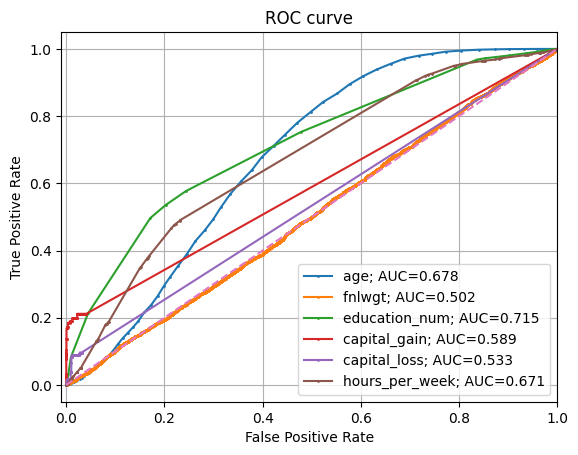

In [8]:
plot_roc(df_adult_test[target], [df_adult_test[c].values for c in numeric], numeric, x_max=1.0)

## Ordered Target Encoding

In [9]:
def ordered_target_encoding(df, target_col, group_col, alpha=0.1):
    mean_ = df[target_col].mean()
    colmap = df.groupby(
        group_col,
    )[target_col].agg(["cumsum", "cumcount"])

    ts_adj = (colmap["cumsum"] - df[target_col] + mean_ * alpha) / (
            colmap["cumcount"] + alpha)

    return ts_adj.loc[df.index]

In [10]:
for col in categorical:
    df_adult[f'{col}_te'] = ordered_target_encoding(df_adult, target, col)

In [11]:
categorical_te = [f'{c}_te' for c in categorical]

In [12]:
target_encode_maps = dict()
for col in categorical:
    target_encode_maps[col] = df_adult.groupby(col)[target].mean().to_dict()

In [13]:
for col, target_encode_map in target_encode_maps.items():
    df_adult_test[f'{col}_te'] = df_adult_test[col].map(target_encode_map)
    df_adult_test[f'{col}_te'].fillna(df_adult[target].mean())

In [14]:
df_adult_test[categorical_te].head()

,workclass_te,education_te,marital_status_te,occupation_te,relationship_te,race_te,sex_te,native_country_te
0,0.218673,0.051064,0.045961,0.124875,0.013220,0.12388,0.305737,0.245835
1,0.218673,0.159509,0.446848,0.115694,0.448571,0.25586,0.305737,0.245835
2,0.294792,0.248360,0.446848,0.325116,0.448571,0.25586,0.305737,0.245835
3,0.218673,0.190235,0.446848,0.124875,0.448571,0.12388,0.305737,0.245835
4,0.104031,0.190235,0.045961,0.103635,0.013220,0.25586,0.109461,0.245835


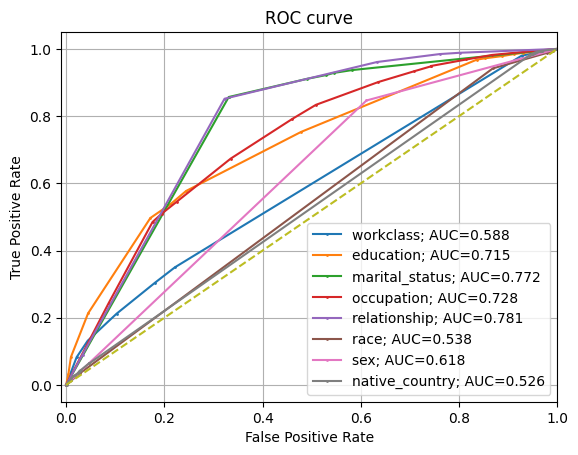

In [15]:
plot_roc(df_adult_test[target], [df_adult_test[c].values for c in categorical_te], categorical, x_max=1.0)

### Binning

In [16]:
df_adult[categorical].nunique()

workclass          9
education         16
marital_status     7
occupation        15
relationship       6
race               5
sex                2
native_country    42
dtype: int64

In [17]:
X_cat = th.tensor(df_adult[categorical_te].values)
y = th.tensor(df_adult[target].values)

X_cat_test = th.tensor(df_adult_test[categorical_te].values)
y_test = th.tensor(df_adult_test[target].values)

In [264]:
def create_X_dt(X_cat, y, X_cat_test, max_splits=None, min_impurity_decrease=0.0):
    assert max_splits is not None or min_impurity_decrease > 0
    X_cat_t = th.zeros_like(X_cat).long()
    X_cat_test_t = th.zeros_like(X_cat_test).long()
    for idx in range(X_cat.shape[1]):
        dtc = DecisionTreeClassifier(max_leaf_nodes=max_splits, min_impurity_decrease=min_impurity_decrease)
        dtc.fit(X_cat[:,idx].reshape((-1,1)), y)
        le = LabelEncoder()
        X_cat_t[:,idx] = th.tensor(le.fit_transform(dtc.apply(X_cat[:,idx].reshape((-1,1))))).long()
        X_cat_test_t[:,idx] = th.tensor(le.transform(dtc.apply(X_cat_test[:,idx].reshape((-1,1))))).long()

    assert X_cat.shape==X_cat_t.shape
    return X_cat_t, X_cat_test_t

In [265]:
max_splits = 3
X_cat_t, X_cat_test_t = create_X_dt(X_cat, y, X_cat_test, max_splits)

In [56]:
impurities = list()
impurities_mean = list()
for idx, dt in enumerate(dts):
    t = dt.tree_
    impurities.append(t.impurity[t.feature<0]*t.n_node_samples[t.feature<0])
    impurities_mean.append(impurities[-1].mean())

In [57]:
aucs = list()
for idx in range(X_cat.shape[1]):
    auc = roc_auc_score(y, X_cat[:,idx])
    aucs.append(max(auc, 1-auc))

In [58]:
# Features rated by their impurity reduction (best to worst)
np.argsort(impurities_mean)

array([4, 2, 1, 3, 6, 0, 5, 7])

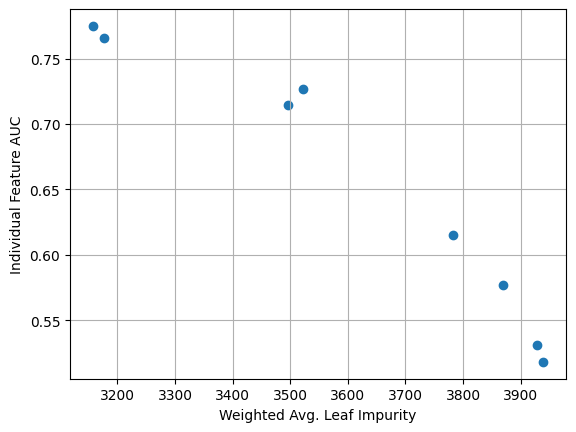

In [59]:
fig, ax = plt.subplots()
ax.scatter(impurities_mean, aucs)
ax.set(xlabel='Weighted Avg. Leaf Impurity', ylabel='Individual Feature AUC')
ax.grid()

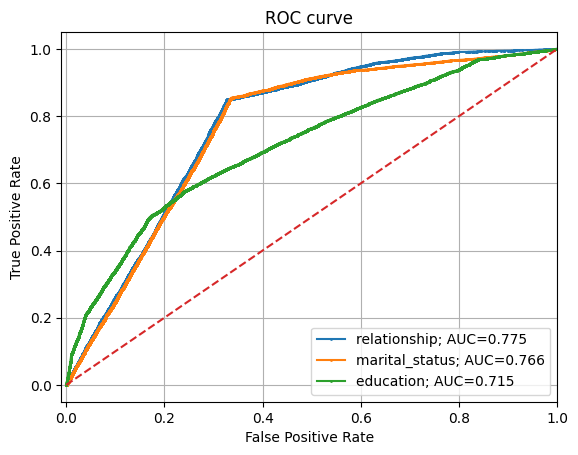

In [60]:
plot_roc(y, [X_cat[:,idx] for idx in [4, 2, 1]], [categorical[idx] for idx in [4, 2, 1]])

### Which categories belong together?

In [61]:
categorical[1]

'education'

In [62]:
X_cat_test_t[:,1]

tensor([0, 0, 0,  ..., 1, 1, 1])

In [63]:
# Stats of each leaf node
df_adult_test.groupby(X_cat_test_t[:,1].numpy())[target].describe()

,count,mean,std,min,25%,50%,75%,max
0,12238.0,0.158114,0.364863,0.0,0.0,0.0,0.0,1.0
1,2670.0,0.408989,0.491739,0.0,0.0,0.0,1.0,1.0
2,1373.0,0.596504,0.490777,0.0,0.0,1.0,1.0,1.0


In [64]:
df_adult_test.groupby(categorical[1])[target].describe()

,count,mean,std,min,25%,50%,75%,max
education,,,,,,,,
10th,456.0,0.054825,0.227888,0.0,0.0,0.0,0.0,1.0
11th,637.0,0.050235,0.218602,0.0,0.0,0.0,0.0,1.0
12th,224.0,0.066964,0.250520,0.0,0.0,0.0,0.0,1.0
1st-4th,79.0,0.025316,0.158088,0.0,0.0,0.0,0.0,1.0
5th-6th,176.0,0.062500,0.242752,0.0,0.0,0.0,0.0,1.0
7th-8th,309.0,0.071197,0.257571,0.0,0.0,0.0,0.0,1.0
9th,242.0,0.057851,0.233946,0.0,0.0,0.0,0.0,1.0
Assoc-acdm,534.0,0.277154,0.448013,0.0,0.0,0.0,1.0,1.0
Assoc-voc,679.0,0.237113,0.425626,0.0,0.0,0.0,0.0,1.0


In [65]:
df_adult_test.loc[X_cat_test_t[:,1].numpy()==0][categorical+[target]]

,workclass,education,marital_status,occupation,relationship,race,sex,native_country,label
0,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,United-States,0
1,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,United-States,0
2,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,United-States,1
3,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,United-States,1
4,?,Some-college,Never-married,?,Own-child,White,Female,United-States,0
...,...,...,...,...,...,...,...,...,...
16270,Private,HS-grad,Married-civ-spouse,Adm-clerical,Husband,White,Male,United-States,0
16271,Private,HS-grad,Married-civ-spouse,Sales,Husband,White,Male,United-States,0
16272,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States,0
16273,Private,HS-grad,Never-married,Other-service,Own-child,White,Female,United-States,0


In [66]:
df_adult_test.groupby([X_cat_test_t[:,1].numpy(), categorical[1]])[target].describe().sort_values(by='mean', ascending=False)

count      mean       std  min  25%  50%  75%  max
  education                                                         
2  Prof-school    258.0  0.751938  0.432727  0.0  1.0  1.0  1.0  1.0
   Doctorate      181.0  0.690608  0.463525  0.0  0.0  1.0  1.0  1.0
   Masters        934.0  0.535332  0.499017  0.0  0.0  1.0  1.0  1.0
1  Bachelors     2670.0  0.408989  0.491739  0.0  0.0  0.0  1.0  1.0
0  Assoc-acdm     534.0  0.277154  0.448013  0.0  0.0  0.0  1.0  1.0
   Assoc-voc      679.0  0.237113  0.425626  0.0  0.0  0.0  0.0  1.0
   Some-college  3587.0  0.188458  0.391132  0.0  0.0  0.0  0.0  1.0
   HS-grad       5283.0  0.156729  0.363580  0.0  0.0  0.0  0.0  1.0
   7th-8th        309.0  0.071197  0.257571  0.0  0.0  0.0  0.0  1.0
   12th           224.0  0.066964  0.250520  0.0  0.0  0.0  0.0  1.0
   5th-6th        176.0  0.062500  0.242752  0.0  0.0  0.0  0.0  1.0
   9th            242.0  0.057851  0.233946  0.0  0.0  0.0  0.0  1.0
   10th           456.0  0.054825  0.227888  0.0  0.0  0.0  0.0  1.0
   11th           637.0  0.050235  0.218602  0.0  0.0  0.0  0.0  1.0
   Preschool       32.0  0.031250  0.176777  0.0  0.0  0.0  0.0  1.0
   1st-4th         79.0  0.025316  0.158088  0.0  0.0  0.0  0.0  1.0

## Train NN
Compare "decision tree" approach to:
- Hashing trick
- Target encoding

In [171]:
def create_X_hash(df_train, df_test, categorical, N_hash):
    X_hash = th.zeros((df_train.shape[0], len(categorical)))
    X_hash_test = th.zeros((df_test.shape[0], len(categorical)))
    for idx, col in enumerate(categorical):
        le = LabelEncoder()
        X_hash[:,idx] = th.tensor(le.fit_transform(df_train[col].values) % N_hash)
        X_hash_test[:,idx] = th.tensor(le.transform(df_test[col].values) % N_hash)

    return X_hash.long(), X_hash_test.long()

In [172]:
N_hash = max_splits
X_hash, X_hash_test = create_X_hash(df_adult, df_adult_test, categorical, N_hash)

In [176]:
# Create: X_hash, X_te, X_dt
X_te, X_te_test = X_cat.float(), X_cat_test.float()
X_dt, X_dt_test = X_cat_t, X_cat_test_t

In [339]:
def train(model, X_train, y_train, X_test, y_test, epochs=200, stop_criteria=5):
    opt = optim.Adam(model.parameters(), lr=0.01)
    train_losses = list()
    test_losses = list()
    min_test_ = 1e8
    es_counter = 0
    for e in range(epochs):
        opt.zero_grad()
        logits = model(X_train)
        loss = F.binary_cross_entropy_with_logits(logits.flatten(), y_train.float())
        loss.backward()
        opt.step()
        
        train_losses.append(loss.item())
        with th.no_grad():
            test_losses.append(
                F.binary_cross_entropy_with_logits(model(X_test).flatten(), y_test.float()).item()
            )
            if test_losses[-1]<min_test_:
                min_test_ = test_losses[-1]
                es_counter = 0
            else:
                es_counter += 1
                
        if es_counter > stop_criteria:
            print(f"Early stopping at epoch {e}")
            break
    return train_losses, test_losses, model(X_test).flatten().sigmoid().detach().numpy()

In [335]:
class MultiIndexEmbedding(nn.Module):
    def __init__(self, n_uniques, h_dim, agg_type='concat'):
        super().__init__()
        
        self.embeds = nn.ModuleList()
        for n_unique in n_uniques:
            self.embeds.append(
                nn.Embedding(n_unique, h_dim)
            )
        assert agg_type in ['concat', 'sum', 'mean']
        self.agg_type = agg_type
    
    def forward(self, X):
        hs = list()
        for idx, embed in enumerate(self.embeds):
            hs.append(embed(X[:,idx]))
        
        if self.agg_type=='concat':
            return th.hstack(hs)
        elif self.agg_type=='sum':
            return th.stack(hs, dim=2).sum(dim=2).squeeze()
        elif self.agg_type=='mean':
            return th.stack(hs, dim=2).mean(dim=2).squeeze()

### Hashing trick

In [179]:
Hk_dim = 2

In [180]:
model_hash = nn.Sequential(MultiIndexEmbedding([N_hash]*len(categorical), Hk_dim, 'concat'), nn.Linear(len(categorical)*Hk_dim, 1))

In [181]:
train_losses_hash, test_losses_hash, y_test_hash = train(model_hash, X_hash, y, X_hash_test, y_test, epochs=200)

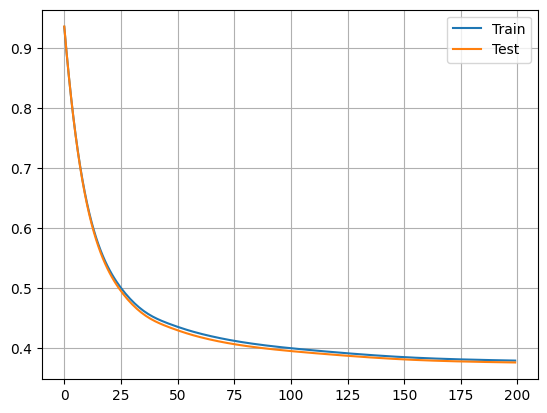

In [182]:
fig, ax = plt.subplots()
ax.plot(train_losses_hash, label='Train')
ax.plot(test_losses_hash, label='Test')
ax.grid()
ax.legend()

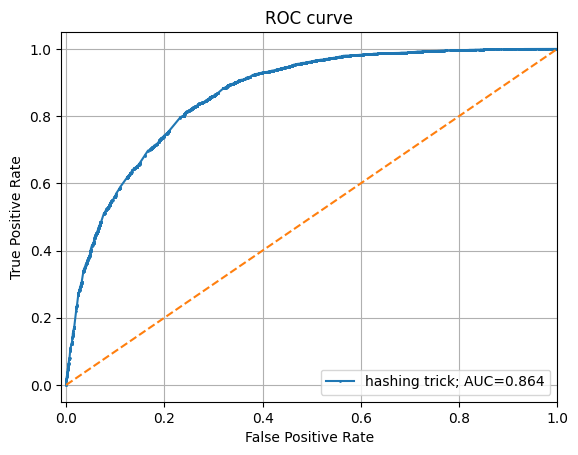

In [183]:
plot_roc(y_test,[y_test_hash], ['hashing trick'])

### Target Encoding

In [184]:
model_te = nn.Linear(len(categorical), 1)

In [185]:
train_losses_te, test_losses_te, y_test_te = train(model_te, X_te, y, X_te_test, y_test, epochs=500)

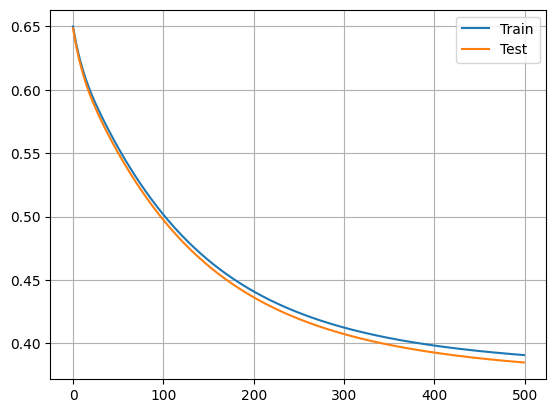

In [186]:
fig, ax = plt.subplots()
ax.plot(train_losses_te, label='Train')
ax.plot(test_losses_te, label='Test')
ax.grid()
ax.legend()

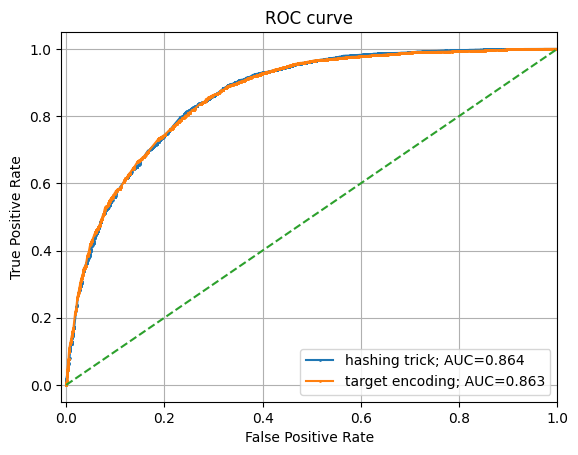

In [187]:
plot_roc(y_test,[y_test_hash, y_test_te], ['hashing trick', 'target encoding'])

### Decision Tree Encoding

In [188]:
model_dt = nn.Sequential(MultiIndexEmbedding([max_splits]*len(categorical), Hk_dim, 'concat'), nn.Linear(len(categorical)*Hk_dim, 1))

In [189]:
train_losses_dt, test_losses_dt, y_test_dt = train(model_dt, X_dt, y, X_dt_test, y_test, epochs=200)

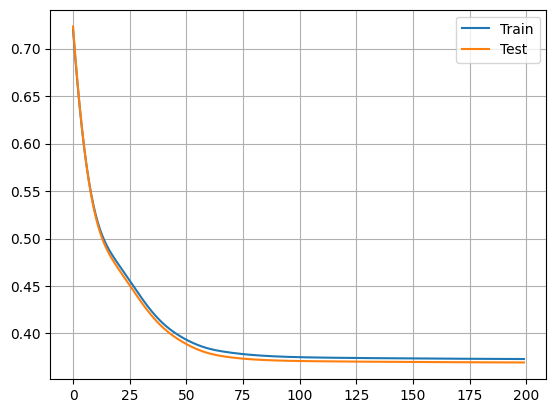

In [190]:
fig, ax = plt.subplots()
ax.plot(train_losses_dt, label='Train')
ax.plot(test_losses_dt, label='Test')
ax.grid()
ax.legend()

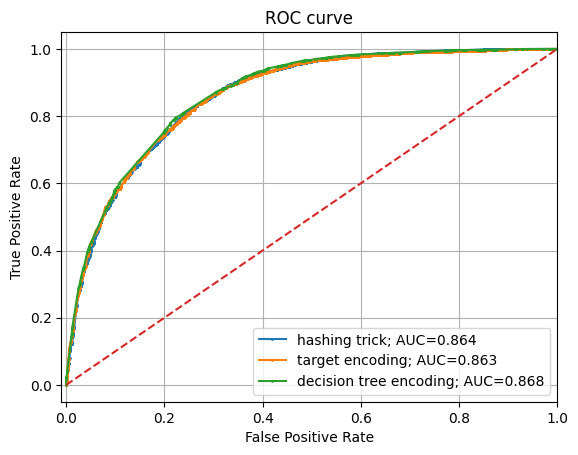

In [191]:
plot_roc(y_test,[y_test_hash, y_test_te, y_test_dt], ['hashing trick', 'target encoding', 'decision tree encoding'])

## Ablate over number of split-points

In [200]:
def split_ablation(min_splits, max_splits, h_dim):
    splits = list()
    y_hashs = list()
    y_dts = list()
    for n_splits in range(min_splits, max_splits+1):
        # hash 
        X_hash, X_hash_test = create_X_hash(df_adult, df_adult_test, categorical, n_splits)
        model_hash = nn.Sequential(
            MultiIndexEmbedding([n_splits]*len(categorical), h_dim, 'concat'), 
            nn.Linear(len(categorical)*h_dim, 1)
        )
        _, _, y_test_hash = train(model_hash, X_hash, y, X_hash_test, y_test, epochs=200)
        
        # dt
        X_cat_t, X_cat_test_t = create_X_dt(X_cat, y, X_cat_test, n_splits)
        model_dt = nn.Sequential(
            MultiIndexEmbedding([n_splits]*len(categorical), h_dim, 'concat'), 
            nn.Linear(len(categorical)*h_dim, 1)
        )
        _, _, y_test_dt = train(model_dt, X_cat_t, y, X_cat_test_t, y_test, epochs=200)
        
        splits.append(n_splits)
        y_hashs.append(y_test_hash)
        y_dts.append(y_test_dt)
    return splits, y_hashs, y_dts

In [413]:
splits, y_hashs, y_dts = split_ablation(2, 10, 2)

Early stopping at epoch 170
Early stopping at epoch 170
Early stopping at epoch 195


In [414]:
aucs_hash = list()
aucs_dts = list()
for y_hash, y_dt in zip(y_hashs, y_dts):
    aucs_hash.append(roc_auc_score(y_test, y_hash))
    aucs_dts.append(roc_auc_score(y_test, y_dt))
    
auc_te = roc_auc_score(y_test, y_test_te)

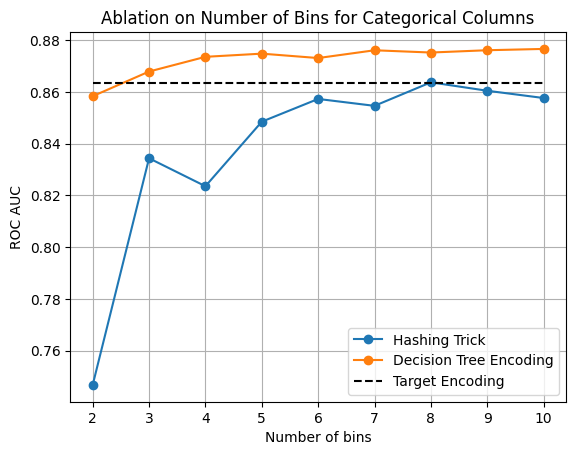

In [415]:
fig, ax = plt.subplots()
ax.plot(splits, aucs_hash, '-o', label='Hashing Trick')
ax.plot(splits, aucs_dts, '-o', label='Decision Tree Encoding')
ax.hlines([auc_te], min(splits), max(splits), linestyle='--', color='black', label='Target Encoding')
ax.legend()
ax.set(
    title='Ablation on Number of Bins for Categorical Columns',
    xlabel='Number of bins', ylabel='ROC AUC'
)
_ = ax.grid()

## Show that growing trees to a minimum impurity reduction auto-selects number of categories

In [374]:
X_cat_t, X_cat_test_t = create_X_dt(X_cat, y, X_cat_test, min_impurity_decrease=8e-5)

In [375]:
n_uniques = (X_cat_t.max(dim=0)[0]+1).numpy()
for name, capacity in zip(categorical, n_uniques):
    print(name, capacity, df_adult[name].nunique())

workclass 7 9
education 14 16
marital_status 10 7
occupation 13 15
relationship 8 6
race 2 5
sex 4 2
native_country 7 42


In [376]:
model_dt_pur = nn.Sequential(
    MultiIndexEmbedding(n_uniques.tolist(), Hk_dim, 'concat'), 
    nn.Linear(len(categorical)*Hk_dim, 1)
)

In [377]:
train_losses_dt_pur, test_losses_dt_pur, y_test_dt_pur = train(model_dt_pur, X_cat_t, y, X_cat_test_t, y_test, epochs=200)

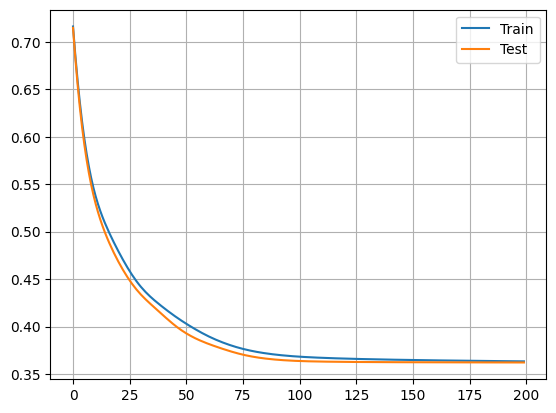

In [378]:
fig, ax = plt.subplots()
ax.plot(train_losses_dt_pur, label='Train')
ax.plot(test_losses_dt_pur, label='Test')
ax.grid()
ax.legend()

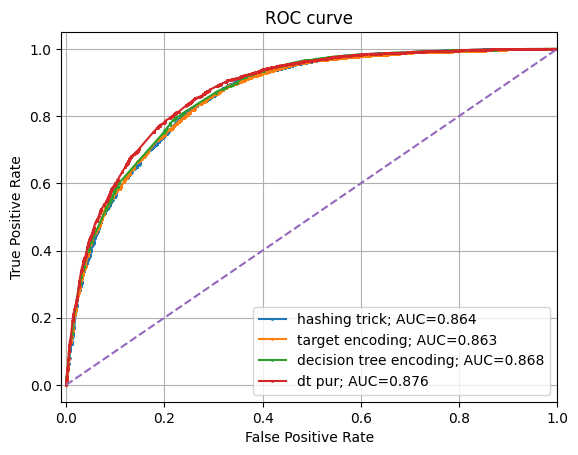

In [379]:
plot_roc(y_test,[y_test_hash, y_test_te, y_test_dt, y_test_dt_pur], ['hashing trick', 'target encoding', 'decision tree encoding', 'dt pur'])

In [380]:
def impurity_ablation(min_impurity, max_impurity, h_dim, n_experiments=10):
    
    splits = list()
    impurs = list()
    y_dts_pur = list()
    y_hashs = list()
    y_dts = list()
    n_params_hash = list()
    n_params_dt = list()
    n_params_pur = list()
    
    for min_impurity_ in np.linspace(min_impurity, max_impurity, n_experiments):
        X_cat_t, X_cat_test_t = create_X_dt(X_cat, y, X_cat_test, min_impurity_decrease=min_impurity_)
        n_uniques = (X_cat_t.max(dim=0)[0]+1).numpy()
        model_dt_pur = nn.Sequential(
            MultiIndexEmbedding(n_uniques, h_dim, 'concat'), 
            nn.Linear(len(categorical)*h_dim, 1)
        )
        _, _, y_test_dt_pur = train(model_dt_pur, X_cat_t, y, X_cat_test_t, y_test, epochs=200)
        
        n_splits = n_uniques.mean().astype(int)+1
    

        # hash 
        X_hash, X_hash_test = create_X_hash(df_adult, df_adult_test, categorical, n_splits)
        model_hash = nn.Sequential(
            MultiIndexEmbedding([n_splits]*len(categorical), h_dim, 'concat'), 
            nn.Linear(len(categorical)*h_dim, 1)
        )
        _, _, y_test_hash = train(model_hash, X_hash, y, X_hash_test, y_test, epochs=200)
        
        # dt
        X_cat_t, X_cat_test_t = create_X_dt(X_cat, y, X_cat_test, n_splits)
        model_dt = nn.Sequential(
            MultiIndexEmbedding([n_splits]*len(categorical), h_dim, 'concat'), 
            nn.Linear(len(categorical)*h_dim, 1)
        )
        _, _, y_test_dt = train(model_dt, X_cat_t, y, X_cat_test_t, y_test, epochs=200)
        
        impurs.append(min_impurity_)
        y_dts_pur.append(y_test_dt_pur)
        splits.append(n_splits)
        y_hashs.append(y_test_hash)
        y_dts.append(y_test_dt)
        n_params_hash.append(sum([p.numel() for p in model_hash.parameters()]))
        n_params_dt.append(sum([p.numel() for p in model_dt.parameters()]))
        n_params_pur.append(sum([p.numel() for p in model_dt_pur.parameters()]))
    return impurs, splits, y_hashs, y_dts, y_dts_pur, n_params_hash, n_params_dt, n_params_pur

In [337]:
impurs, splits_2, y_hashs_2, y_dts_2, y_dts_pur, n_params_hash, n_params_dt, n_params_pur = impurity_ablation(
    5e-5, 1e-3, Hk_dim, 10,
)

In [410]:
def num_ps(n_splits, h_dim):
    return n_splits*h_dim*len(categorical)+len(categorical)*h_dim+1

In [345]:
aucs_hash_2 = list()
aucs_dts_2 = list()
aucs_pur = list()
for y_hash, y_dt, y_pur in zip(y_hashs_2, y_dts_2, y_dts_pur):
    aucs_hash_2.append(roc_auc_score(y_test, y_hash))
    aucs_dts_2.append(roc_auc_score(y_test, y_dt))
    aucs_pur.append(roc_auc_score(y_test, y_pur))

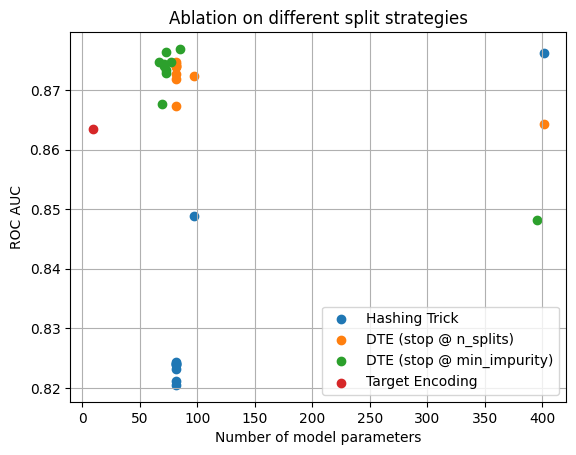

In [416]:
fig, ax = plt.subplots()
ax.scatter(n_params_hash, aucs_hash_2, label='Hashing Trick')
ax.scatter(n_params_dt, aucs_dts_2, label='DTE (stop @ n_splits)')
ax.scatter(n_params_pur, aucs_pur, label='DTE (stop @ min_impurity)')
ax.scatter(sum([p.numel() for p in model_te.parameters()]), auc_te, label='Target Encoding')
ax.legend()
ax.set(
    title='Ablation on different split strategies',
    xlabel='Number of model parameters', ylabel='ROC AUC'
)
_ = ax.grid()

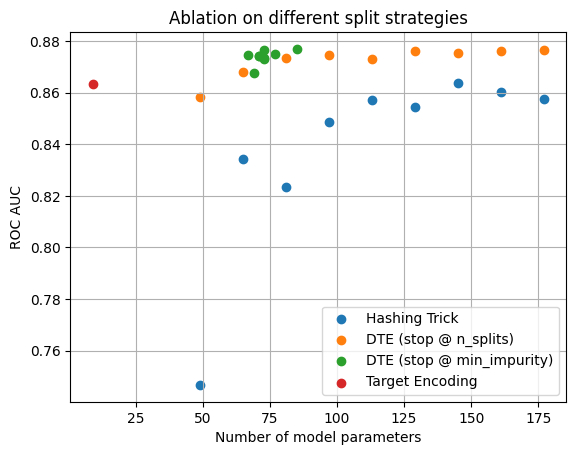

In [424]:
fig, ax = plt.subplots()
ax.scatter([num_ps(s, 2) for s in splits], aucs_hash, label='Hashing Trick')
ax.scatter([num_ps(s, 2) for s in splits], aucs_dts, label='DTE (stop @ n_splits)')
ax.scatter(n_params_pur[1:], aucs_pur[1:], label='DTE (stop @ min_impurity)')
ax.scatter(sum([p.numel() for p in model_te.parameters()]), auc_te, label='Target Encoding')

ax.legend()
ax.set(
    title='Ablation on different split strategies',
    xlabel='Number of model parameters', ylabel='ROC AUC'
)
_ = ax.grid()

## Unsupervised
- Frequency encoding
- Random subsets
  - I think this will be identical to hashing trick

In [461]:
from sklearn.ensemble import RandomTreesEmbedding

In [568]:
def create_X_freq(df_train, df_test, categorical):
    X_freq = th.zeros((df_train.shape[0], len(categorical)))
    X_freq_test = th.zeros((df_test.shape[0], len(categorical)))
    for idx, col in enumerate(categorical):
        # val_map = {
        #     category: c_i 
        #     for c_i, category in enumerate(df_train[col].value_counts().head(N_unique-1).index.values)
        # }
        val_map = df_train[col].value_counts().to_dict()
        # print(val_map)
        X_freq[:,idx] = th.tensor(df_train[col].map(val_map))
        X_freq_test[:,idx] = th.tensor(df_test[col].apply(lambda x: val_map.get(x, 0)).values)

    return X_freq.long(), X_freq_test.long()

def create_X_dt_unsuper(X_freq, X_freq_test, max_splits):
    assert max_splits > 0
    X_freq_t = th.zeros_like(X_freq).long()
    X_freq_test_t = th.zeros_like(X_freq_test).long()
    for idx in range(X_freq.shape[1]):
        rte = RandomTreesEmbedding(n_estimators=1, max_leaf_nodes=max_splits, sparse_output=False)
        rte.fit(X_freq[:,idx].reshape((-1,1)))
        le = LabelEncoder()
        X_freq_t[:,idx] = th.tensor(le.fit_transform(rte.apply(X_freq[:,idx].reshape((-1,1))).flatten())).long()
        X_freq_test_t[:,idx] = th.tensor(le.transform(rte.apply(X_freq_test[:,idx].reshape((-1,1))).flatten())).long()

    assert X_freq.shape==X_freq_t.shape
    return X_freq_t.long(), X_freq_test_t.long()

def create_X_top(df_train, df_test, categorical, N_unique):
    X_freq = th.zeros((df_train.shape[0], len(categorical)))
    X_freq_test = th.zeros((df_test.shape[0], len(categorical)))
    for idx, col in enumerate(categorical):
        val_map = {
            category: c_i 
            for c_i, category in enumerate(df_train[col].value_counts().head(N_unique-1).index.values)
        }
        # print(val_map)
        X_freq[:,idx] = th.tensor(df_train[col].apply(lambda x: val_map.get(x, N_unique-1)).values)
        X_freq_test[:,idx] = th.tensor(df_test[col].apply(lambda x: val_map.get(x, N_unique-1)).values)

    return X_freq.long(), X_freq_test.long()

In [569]:
X_freq, X_freq_test = create_X_freq(df_adult, df_adult_test, categorical)

In [570]:
X_freq_top, X_freq_top_test = create_X_top(df_adult, df_adult_test, categorical, 5)

In [573]:
X_freq_t, X_freq_test_t = create_X_dt_unsuper(X_freq, X_freq_test, 5)

In [574]:
def unsuper_ablation(min_unique, max_unique, h_dim):
    splits = list()
    y_dts = list()
    y_tops = list()
    for n_splits in range(min_unique, max_unique+1):
        # dt unsuper
        X_freq_t, X_freq_test_t = create_X_dt_unsuper(X_freq, X_freq_test, n_splits)
        model_dt = nn.Sequential(
            MultiIndexEmbedding([n_splits]*len(categorical), h_dim, 'concat'), 
            nn.Linear(len(categorical)*h_dim, 1)
        )
        _, _, y_test_dt = train(model_dt, X_freq_t, y, X_freq_test_t, y_test, epochs=200)
        
        # top
        X_freq_top, X_freq_top_test = create_X_top(df_adult, df_adult_test, categorical, n_splits)
        model_dt = nn.Sequential(
            MultiIndexEmbedding([n_splits]*len(categorical), h_dim, 'concat'), 
            nn.Linear(len(categorical)*h_dim, 1)
        )
        _, _, y_top = train(model_dt, X_freq_top, y, X_freq_top_test, y_test, epochs=200)
        
        
        splits.append(n_splits)
        y_dts.append(y_test_dt)
        y_tops.append(y_top)
    return splits, y_dts, y_tops

In [575]:
splits_3, y_dts_unsup, y_tops = unsuper_ablation(2, 10, 2)

In [576]:
aucs_unsup = list()
aucs_top = list()
for y_unsup, y_top in zip(y_dts_unsup, y_tops):
    aucs_unsup.append(roc_auc_score(y_test, y_unsup))
    aucs_top.append(roc_auc_score(y_test, y_top))

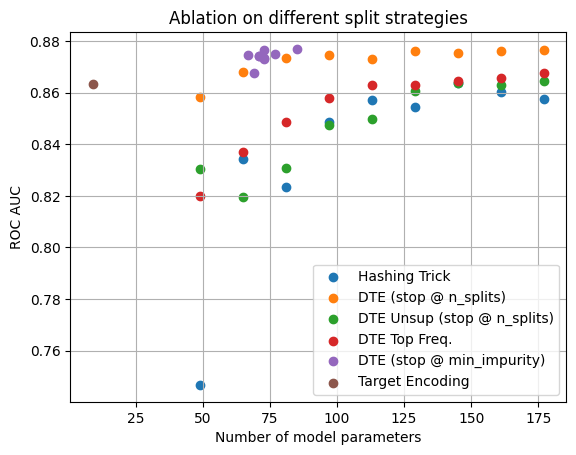

In [578]:
fig, ax = plt.subplots()
ax.scatter([num_ps(s, 2) for s in splits], aucs_hash, label='Hashing Trick')
ax.scatter([num_ps(s, 2) for s in splits], aucs_dts, label='DTE (stop @ n_splits)')
ax.scatter([num_ps(s, 2) for s in splits_3], aucs_unsup, label='DTE Unsup (stop @ n_splits)')
ax.scatter([num_ps(s, 2) for s in splits_3], aucs_top, label='DTE Top Freq.')

ax.scatter(n_params_pur[1:], aucs_pur[1:], label='DTE (stop @ min_impurity)')
ax.scatter(sum([p.numel() for p in model_te.parameters()]), auc_te, label='Target Encoding')

ax.legend()
ax.set(
    title='Ablation on different split strategies',
    xlabel='Number of model parameters', ylabel='ROC AUC'
)
_ = ax.grid()